In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import io
import os
import json
import time
import sys
import math
import copy
import pickle
import zipfile
from textwrap import wrap
from pathlib import Path
from itertools import zip_longest
from collections import defaultdict
from urllib.error import URLError
from urllib.request import urlopen

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch import optim
from torch import tensor
from torch.nn import functional as F 
from torch.optim.lr_scheduler import _LRScheduler

In [3]:
sys.path.append("src/")
from constants import *

## Experiment 2 - MF with deep NN

In [4]:
from torch.utils.data import IterableDataset
from itertools import chain, islice


class InteractionsStream(IterableDataset):

    def __init__(self, prep_data_dir=PREPARED_DATA_DIR, file_num=None,
                 sample='train', user_col='User', item_col='Movie',
                 end_token='.h5', start_token='user_{}_data_',
                 baseline_feats=False, model_type='regression',
                 chunksize=10):

        if file_num is None:
            self.files = [os.path.join(prep_data_dir, x) for x in
                          _find_files(prep_data_dir,
                                      start_token.format(sample),
                                      end_token)]
        else:
            self.files = [
                os.path.join(prep_data_dir,
                             start_token.format(sample)+str(file_num)+
                             end_token)]
        print(self.files)
        self.user_col = user_col
        self.item_col = item_col
        self.baseline_feats = baseline_feats
        self.sample = sample
        self.chunksize = chunksize
        if model_type == 'regression':
            self.dv_col = 'Rating'
        elif model_type == 'classification':
            self.dv_col = 'Rating_class'
        self.cat_cols = [self.user_col, self.item_col]
        
        if baseline_feats:
            self.numeric_cols = [
                'days_since_first_user_rating',
                'sqrt_days_since_first_user_rating',
                'rating_age_days_user', 'rating_age_weeks_user',
                'rating_age_months_user', 'mean_ratings_user',
                'num_ratings_user', 'days_since_first_item_rating',
                'sqrt_days_since_first_item_rating',
                'rating_age_days_item', 'rating_age_weeks_item',
                'rating_age_months_item', 'mean_ratings_movie',
                'weighted_mean_ratings_movie', 'num_ratings_movie']
        else:
            self.numeric_cols = []            

    def read_file(self, fn):
        
        if self.sample == 'train':
            df = pd.read_hdf(fn, key='stage', iterator=True,
                             chunksize=self.chunksize)
        else:
            df = pd.read_hdf(fn, key='stage')
        
        return df       

    def process_data(self, fn):

        print('read data')
        data = self.read_file(fn)

        if self.sample == 'train':
            for row in data:
                user = row[self.user_col].tolist()
                item = row[self.item_col].tolist()
                y = row[self.dv_col].tolist()
                yield (user, item), y
        else:
            for i, row in data.iterrows():
                yield (row[self.user_col],
                       row[self.item_col]), row[self.dv_col]

    def get_stream(self, files):
        return chain.from_iterable(map(self.process_data, files))

    def __iter__(self):
        return self.get_stream(self.files)

In [64]:
class EmbeddingNet(nn.Module):
    """
    Creates a dense network with embedding layers.
    
    Args:
    
        n_users:            
            Number of unique users in the dataset.

        n_movies: 
            Number of unique movies in the dataset.

        n_factors: 
            Number of columns in the embeddings matrix.

        embedding_dropout: 
            Dropout rate to apply right after embeddings layer.

        hidden:
            A single integer or a list of integers defining the number of 
            units in hidden layer(s).

        dropouts: 
            A single integer or a list of integers defining the dropout 
            layers rates applyied right after each of hidden layers.
            
    """
    def __init__(self, n_users, n_movies,
                 n_factors=50, embedding_dropout=0.02, 
                 hidden=10, dropouts=0.2):
        
        super().__init__()
        hidden = get_list(hidden)
        dropouts = get_list(dropouts)
        n_last = hidden[-1]
        
        def gen_layers(n_in):
            """
            A generator that yields a sequence of hidden layers and 
            their activations/dropouts.
            
            Note that the function captures `hidden` and `dropouts` 
            values from the outer scope.
            """
            nonlocal hidden, dropouts
            assert len(dropouts) <= len(hidden)
            
            for n_out, rate in zip_longest(hidden, dropouts):
                yield nn.Linear(n_in, n_out)
                yield nn.ReLU()
                if rate is not None and rate > 0.:
                    yield nn.Dropout(rate)
                n_in = n_out
            
        self.u = nn.Embedding(n_users, n_factors)
        self.m = nn.Embedding(n_movies, n_factors)
        self.drop = nn.Dropout(embedding_dropout)
        self.hidden = nn.Sequential(*list(gen_layers(n_factors * 2)))
        self.fc = nn.Linear(n_last, 1)
        self._init()
        
    def forward(self, users, movies, minmax=None):
        features = torch.cat([self.u(users), self.m(movies)], dim=1)
        x = self.drop(features)
        x = self.hidden(x)
        out = torch.sigmoid(self.fc(x))
        if minmax is not None:
            min_rating, max_rating = minmax
            out = out*(max_rating - min_rating + 1) + min_rating - 0.5
        
        return out
    
    def _init(self):
        """
        Setup embeddings and hidden layers with reasonable initial values.
        """
        
        def init(m):
            if type(m) == nn.Linear:
                torch.nn.init.xavier_uniform_(m.weight)
                m.bias.data.fill_(0.01)
                
        self.u.weight.data.uniform_(-0.05, 0.05)
        self.m.weight.data.uniform_(-0.05, 0.05)
        self.hidden.apply(init)
        init(self.fc)
    
    
def get_list(n):
    if isinstance(n, (int, float)):
        return [n]
    elif hasattr(n, '__iter__'):
        return list(n)
    raise TypeError('layers configuraiton should be a single number \
                    or a list of numbers')

In [65]:
class CyclicLR(_LRScheduler):
    
    def __init__(self, optimizer, schedule, last_epoch=-1):
        assert callable(schedule)
        self.schedule = schedule
        super().__init__(optimizer, last_epoch)

    def get_lr(self):
        return [self.schedule(self.last_epoch, lr) for lr in
                self.base_lrs]

In [66]:
def triangular(step_size, max_lr, method='triangular', gamma=0.99):
    
    def scheduler(epoch, base_lr):
        period = 2 * step_size
        cycle = math.floor(1 + epoch/period)
        x = abs(epoch/step_size - 2*cycle + 1)
        delta = (max_lr - base_lr)*max(0, (1 - x))

        if method == 'triangular':
            pass  # we've already done
        elif method == 'triangular2':
            delta /= float(2 ** (cycle - 1))
        elif method == 'exp_range':
            delta *= (gamma**epoch)
        else:
            raise ValueError('unexpected method: %s' % method)
            
        return base_lr + delta
        
    return scheduler

In [67]:
def cosine(t_max, eta_min=0):
    
    def scheduler(epoch, base_lr):
        t = epoch % t_max
        return eta_min + (base_lr - eta_min)*(1 + math.cos(
            math.pi*t/t_max))/2
    
    return scheduler

In [68]:
def plot_lr(schedule):
    ts = list(range(1000))
    y = [schedule(t, 0.001) for t in ts]
    plt.plot(ts, y)

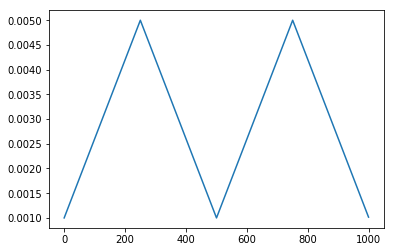

In [69]:
plot_lr(triangular(250, 0.005))

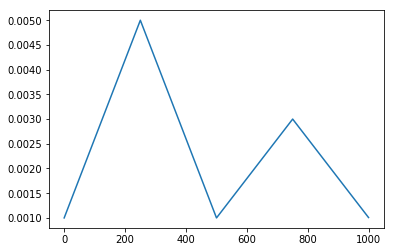

In [70]:
plot_lr(triangular(250, 0.005, 'triangular2'))

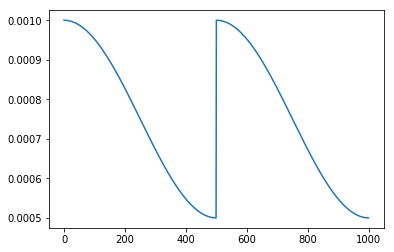

In [71]:
plot_lr(cosine(t_max=500, eta_min=0.0005))

In [72]:
# GLOBALS
FILE_NUM = 1
N_USERS = 480189
N_ITEMS = 17770
BATCH_SIZE = 500
TRAIN_SIZE = 22851074 # corresponds to FILE_NUM
VAL_SIZE = 962152     # corresponds to FILE_NUM
TEST_SIZE = 240538    # corresponds to FILE_NUM

In [117]:
net = EmbeddingNet(
    n_users=N_USERS, n_movies=N_ITEMS, 
    n_factors=100, hidden=[100], 
    embedding_dropout=0.05, dropouts=[0.5])

In [118]:
net

EmbeddingNet(
  (u): Embedding(480189, 100)
  (m): Embedding(17770, 100)
  (drop): Dropout(p=0.05, inplace=False)
  (hidden): Sequential(
    (0): Linear(in_features=200, out_features=100, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
  )
  (fc): Linear(in_features=100, out_features=1, bias=True)
)

In [119]:
minmax = (1., 5.)
minmax

(1.0, 5.0)

In [120]:
import torch
from torch import nn, tensor
import numpy as np
import collections, copy

from abc import ABCMeta
from abc import abstractmethod
from typing import Callable
from tqdm import tqdm


class StepBase:
    """Defines the interface that all step models here expose."""
    __metaclass__ = ABCMeta

    @abstractmethod
    def batch_fit(self, data_loader: torch.utils.data.DataLoader, epochs: int):
        """Trains the model on a batch of user-item interactions."""
        pass

    @abstractmethod
    def step(self, user: torch.tensor, item: torch.tensor,
             rating: torch.tensor, preference: torch.tensor):
        """Trains the model incrementally."""
        pass

    @abstractmethod
    def predict(self, user: torch.tensor, k: int):
        """Recommends the top-k items to a specific user."""
        pass

    @abstractmethod
    def save(self, path: str):
        """Saves the model parameters to the given path."""
        pass

    @abstractmethod
    def load(self, path: str):
        """Loads the model parameters from a given path."""
        pass
    
    
class Step(StepBase):
    """batch training of recommender systems."""
    
    def __init__(self, model: torch.nn.Module, train_size, test_size,
                 loss_function=torch.nn.MSELoss(reduction='sum'),
                 optimizer = torch.optim.Adam,
                 lr = 0.01, weight_decay = 0., batch_size=512,
                 chunksize=10, patience=2, minmax=(1., 5.)):
        
        self.loss_function = loss_function
        self.lr = lr
        self.batch_size = batch_size
        self.chunksize = chunksize
        self.weight_decay = weight_decay
        self.patience = patience
        self.minmax = minmax
        self.train_size = train_size
        self.test_size = test_size
        self.device = torch.device('cuda:0' if torch.cuda.is_available()
                                   else 'cpu')
        self.model = model.to(self.device)
        self.optimizer = optimizer(self.model.parameters(),
                                   lr=self.lr,
                                   weight_decay=self.weight_decay)
        self.iterations_per_epoch = int(math.ceil(
            self.train_size // (self.batch_size * self.chunksize)))
        self.scheduler = CyclicLR(self.optimizer, cosine(
            t_max=self.iterations_per_epoch * 2, eta_min=self.lr/10))
        self.history = []
        self.lr_history = []
        self.best_loss = np.inf
        self.best_weights = None

        # check if the user has provided user and item embeddings
        assert self.model.u, 'User embedding matrix could not be found.'
        assert self.model.m, 'Item embedding matrix could not be found.'

    @property
    def user_embeddings(self):
        return self.model.u

    @property
    def item_embeddings(self):
        return self.model.m
    
    def construct_tensor(self, a):
        out = [] 
        for i in a: 
            out += i.tolist() 
        return tensor(out)
    
    def train_model(self, data_loader: torch.utils.data.DataLoader):
        
        self.model.train()
        sum_loss = 0
        total = 0
        with tqdm(total=self.train_size //(self.batch_size *
                                           self.chunksize)) as pbar:
            for _, ((row, col), val) in enumerate(data_loader):
                row = self.construct_tensor(row).long().to(self.device)
                col = self.construct_tensor(col).long().to(self.device)
                val = self.construct_tensor(val).float().to(self.device)
                print(row)
                print(col)
                print(val)
                print(val.size())
                batch = val.size()[0]
                total += batch
                print(total)
                output = self.model(row, col, self.minmax)
                print(output)
                loss = self.loss_function(output, val)
                print(loss)
                self.optimizer.zero_grad()
                self.scheduler.step()
                loss.backward()
                self.optimizer.step()
                self.lr_history.extend(self.scheduler.get_lr())
                sum_loss += loss.item()
                print(sum_loss)
                pbar.update(1)
        
        return sum_loss/total

    def batch_fit(self, train_data_loader: torch.utils.data.DataLoader,
                  test_data_loader: torch.utils.data.DataLoader,
                  epochs: int = 1, val_flag=True):
        """Trains the model on a batch of user-item interactions."""
        
        no_improvements = 0
        for epoch in range(epochs):
            stats = {'epoch': epoch + 1, 'total': epochs}
            loss = self.train_model(train_data_loader)
            stats['train'] = loss
            if val_flag:
                print('estimating loss on the test set')
                val_loss = self._validation_loss(test_data_loader)
                stats['val'] = val_loss
                
                if val_loss < self.best_loss:
                    print('loss improvement on epoch: %d' % (epoch + 1))
                    self.best_loss = val_loss
                    self.best_weights = copy.deepcopy(
                        self.model.state_dict())
                    no_improvements = 0
                else:
                    no_improvements += 1
            print(loss)
            
            self.history.append(stats)
            print('[{epoch:03d}/{total:03d}] train: {train:.4f} - val: {val:.4f}'.format(**stats))
            if no_improvements >= self.patience:
                print('early stopping after epoch {epoch:03d}'.format(**stats))
                break
            
    def _validation_loss(self, data_loader: torch.utils.data.DataLoader):
        
        self.model.eval()
        sum_loss = 0
        with tqdm(total=self.test_size // self.batch_size) as pbar:
            for _, ((row, col), val) in enumerate(data_loader):
                row = row.long().to(self.device)
                col = col.long().to(self.device)
                val = val.float().to(self.device)
                output = self.model(row, col, self.minmax)
                loss = self.loss_function(output, val)
                sum_loss += loss.item()
                pbar.update(1)
        
        return sum_loss/self.test_size

    def save(self, path: str):
        """Saves the best model's parameters to the given path."""
        torch.save(self.best_weights, path)

    def load(self, path: str):
        """Loads the model parameters from a given path."""
        if path is not None:
            self.model.load_state_dict(torch.load(path))
        else:
            self.model.load_state_dict(self.best_weights)

In [129]:
model = Step(net, train_size=TRAIN_SIZE, test_size=TEST_SIZE,
             lr=0.02, weight_decay=0.1, batch_size=1,
             chunksize=5, patience=2, minmax=None)

In [130]:
from torch.utils.data import DataLoader


train_dataset = InteractionsStream(
    file_num=FILE_NUM, baseline_feats=False, model_type='regression',
    sample='train', chunksize=5)
train_loader = DataLoader(train_dataset, batch_size=1,
                          shuffle=False)

test_dataset = InteractionsStream(file_num=FILE_NUM, baseline_feats=False,
                                  model_type='regression', sample='test')
test_loader = DataLoader(test_dataset, batch_size=1,
                         shuffle=False)

['/Users/varunn/Documents/kaggle/netflix-prize-data/prepared_data_for_NN_modelling/user_train_data_1.h5']
['/Users/varunn/Documents/kaggle/netflix-prize-data/prepared_data_for_NN_modelling/user_test_data_1.h5']


In [131]:
start = time.time()
model.batch_fit(train_data_loader=train_loader,
                test_data_loader=test_loader, val_flag=True, epochs=2)
print('time taken: %0.2f' % (time.time() - start))

  0%|          | 0/4570214 [00:00<?, ?it/s]/Users/varunn/.virtualenvs/rasa/lib/python3.6/site-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([5])) that is different to the input size (torch.Size([5, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


read data
tensor([161459,  87375, 191296,  27266, 175666])
tensor([2138, 3253, 1154, 1201, 4377])
tensor([4., 2., 2., 5., 3.])
torch.Size([5])
5
tensor([[0.9995],
        [0.9999],
        [0.9935],
        [0.9999],
        [0.9995]], grad_fn=<SigmoidBackward>)
tensor(155.1674, grad_fn=<MseLossBackward>)


  0%|          | 1/4570214 [00:01<1870:31:24,  1.47s/it]

155.1674346923828
tensor([141629, 252679, 134412, 130415, 296886])
tensor([1405,  289, 4340, 2339, 1026])
tensor([3., 3., 3., 3., 4.])
torch.Size([5])
10
tensor([[0.9997],
        [0.9984],
        [0.9998],
        [0.9998],
        [0.9929]], grad_fn=<SigmoidBackward>)
tensor(125.2098, grad_fn=<MseLossBackward>)


  0%|          | 2/4570214 [00:02<1635:16:03,  1.29s/it]

280.37718963623047
tensor([398255, 122198,  86100, 187857, 405639])
tensor([4487, 1641, 3417, 1901, 3127])
tensor([3., 3., 3., 3., 3.])
torch.Size([5])
15
tensor([[0.9547],
        [0.8743],
        [0.9682],
        [0.9459],
        [0.9727]], grad_fn=<SigmoidBackward>)
tensor(105.7955, grad_fn=<MseLossBackward>)


  0%|          | 3/4570214 [00:03<1459:53:32,  1.15s/it]

386.1727066040039
tensor([109577,  55618, 383780, 392816, 392221])
tensor([ 995, 2560, 3902,  329, 1832])
tensor([5., 3., 4., 3., 1.])
torch.Size([5])
20
tensor([[0.9392],
        [0.9115],
        [0.9331],
        [0.8758],
        [0.9474]], grad_fn=<SigmoidBackward>)
tensor(173.8171, grad_fn=<MseLossBackward>)


KeyboardInterrupt: 

In [24]:
model_fn = os.path.join(MODEL_DIR, 'model_NN_DeepMF_{}_E3.pt'.format(
    FILE_NUM))
model.save(model_fn)

[autoreload of six failed: Traceback (most recent call last):
  File "/Users/varunn/.virtualenvs/rasa/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/Users/varunn/.virtualenvs/rasa/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 450, in superreload
    update_generic(old_obj, new_obj)
  File "/Users/varunn/.virtualenvs/rasa/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 387, in update_generic
    update(a, b)
  File "/Users/varunn/.virtualenvs/rasa/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 327, in update_class
    old_obj = getattr(old, key)
  File "/Users/varunn/.virtualenvs/rasa/lib/python3.6/site-packages/six.py", line 93, in __get__
    setattr(obj, self.name, result)  # Invokes __set__.
AttributeError: 'NoneType' object has no attribute 'cStringIO'
]
[autoreload of dateutil.parser failed: Traceback (most recent call last):
  Fil

In [78]:
model.minmax, model.device, model.model

(None, device(type='cpu'), EmbeddingNet(
   (u): Embedding(480189, 150)
   (m): Embedding(17770, 150)
   (drop): Dropout(p=0.05, inplace=False)
   (hidden): Sequential(
     (0): Linear(in_features=300, out_features=500, bias=True)
     (1): ReLU()
     (2): Dropout(p=0.5, inplace=False)
     (3): Linear(in_features=500, out_features=500, bias=True)
     (4): ReLU()
     (5): Dropout(p=0.5, inplace=False)
     (6): Linear(in_features=500, out_features=500, bias=True)
     (7): ReLU()
     (8): Dropout(p=0.25, inplace=False)
   )
   (fc): Linear(in_features=500, out_features=1, bias=True)
 ))

In [39]:
# get prediction for test set

preds = []
actuals = []
with torch.no_grad():
    for _, ((row, col), val) in enumerate(test_loader):
        row = row.long().to(model.device)
        col = col.long().to(model.device)
        val = val.float().to(model.device)
        pred = model.model(row, col, minmax)
        preds.append(pred.tolist())
        actuals.append(val.tolist())

read data


In [42]:
len(actuals), len(preds)

(482, 482)

In [36]:
final_preds = [item for sublist in preds for item in sublist]
final_actuals = [item for sublist in actuals for item in sublist]

In [37]:
len(final_preds), len(final_actuals)

(240538, 240538)

In [38]:
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(y_true=final_actuals,
                                  y_pred=final_preds))
print('Test RMSE: %0.4f' % (rmse))

Test RMSE: 3.1676
